<a href="https://colab.research.google.com/github/SuminBae97/PytorchStudy/blob/main/For.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mxnet

In [ ]:
pip install --upgrade mxnet~=1.7 gluonts

In [3]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json

In [4]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)


<h1>Twitter time series data forecast</h1>
<h1>5분 frequency</h1>

In [15]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


<h1>dataset 호출</h1>
<h1>1시간의 시간간격 데이터</h1>

In [16]:
dataset = get_dataset('m4_hourly',regenerate=True)

saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json
saving time-series into /root/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


In [26]:
train = list(dataset.train)
test = list(dataset.test)

In [49]:
to_pandas(train[1]).index[-1]

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


Timestamp('1750-01-30 03:00:00', freq='H')

<h1>Total 414개의 time series, 700개의 time index(1시간 간격)</h1>

In [28]:
len(train), train[0]['target'].shape , len(test), test[0]['target'].shape

(414, (700,), 414, (748,))

In [93]:
to_pandas(train[0])

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-29 23:00:00    790.0
1750-01-30 00:00:00    784.0
1750-01-30 01:00:00    752.0
1750-01-30 02:00:00    739.0
1750-01-30 03:00:00    684.0
Freq: H, Length: 700, dtype: float32

In [94]:
to_pandas(test[0])

/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


1750-01-01 00:00:00    605.0
1750-01-01 01:00:00    586.0
1750-01-01 02:00:00    586.0
1750-01-01 03:00:00    559.0
1750-01-01 04:00:00    511.0
                       ...  
1750-01-31 23:00:00    785.0
1750-02-01 00:00:00    756.0
1750-02-01 01:00:00    719.0
1750-02-01 02:00:00    703.0
1750-02-01 03:00:00    659.0
Freq: H, Length: 748, dtype: float32

<h1>Task:  414개의 time series 데이터의 700 timeindex를 학습 후 48개의 time index forecast</h1>

In [75]:
print(f"Length of forecasting window in test dataset: {len(to_pandas(test[0])) - len(to_pandas(train[0]))}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


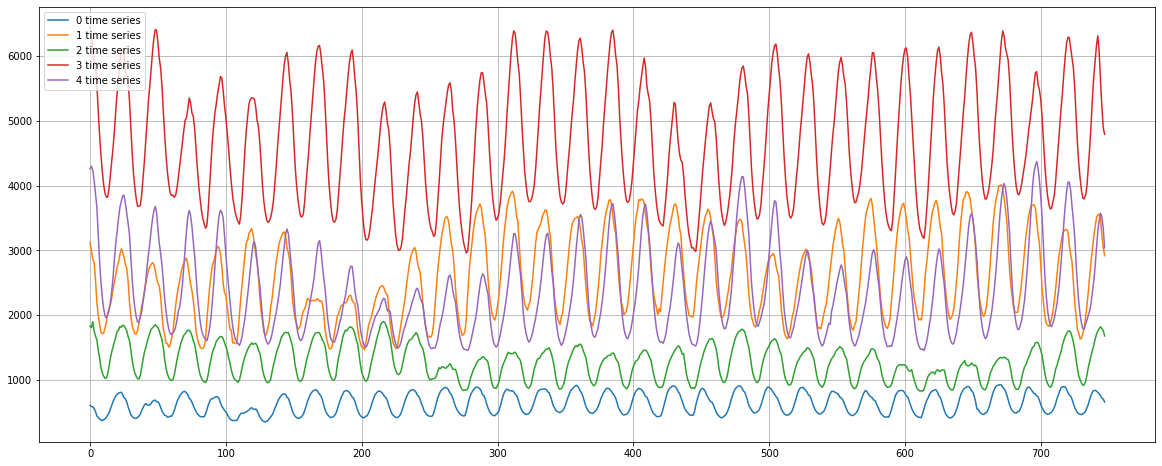

In [90]:
plt.figure(figsize=(20,8))
for i in range(0,5):
    plt.plot(test[i]['target'],label=f'{i} time series')
    #tmp  = to_pandas(train[i])
    
plt.grid(which='both')
plt.legend()

In [72]:
# plt.figure(figsize=(20,8))
# plt.plot(to_pandas(test[10]))
# plt.axvline(to_pandas(train[10]).index[-1],color='r')
# plt.grid(which='both')

def plot_ax(i):
    plt.figure(figsize=(15,4))
    plt.title(f'{i}th time series')
    plt.plot(to_pandas(test[i]))
    plt.axvline(to_pandas(train[i]).index[-1],color='r')
    plt.grid(which='both')



/usr/local/lib/python3.7/dist-packages/gluonts/dataset/util.py:136: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


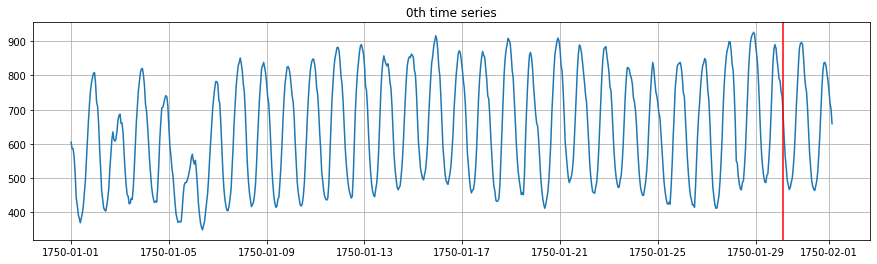

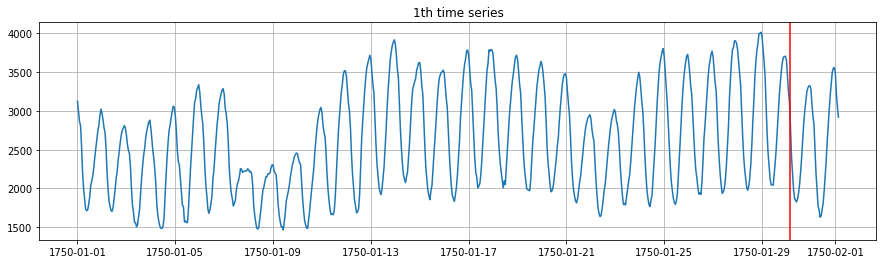

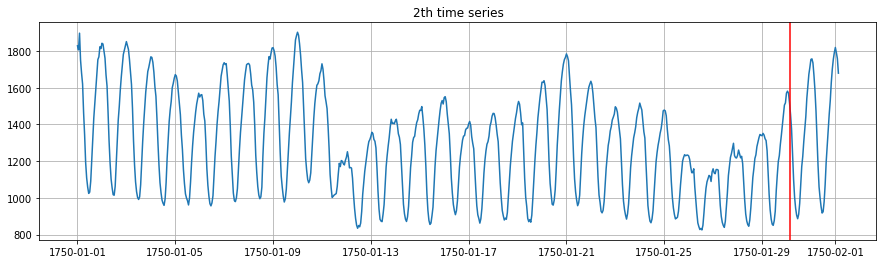

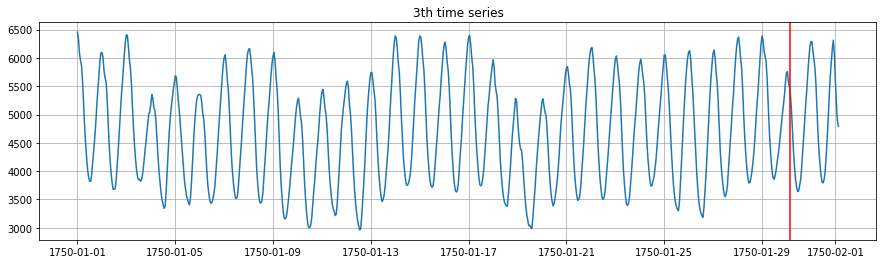

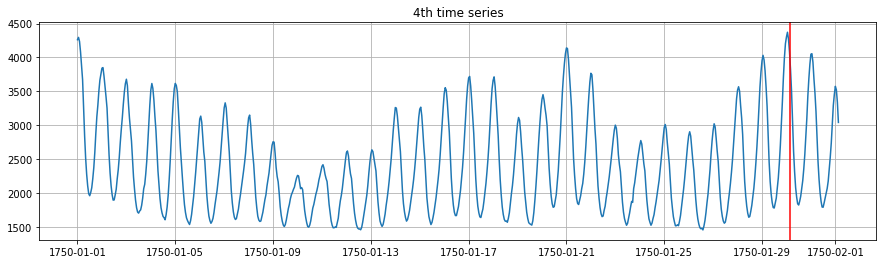

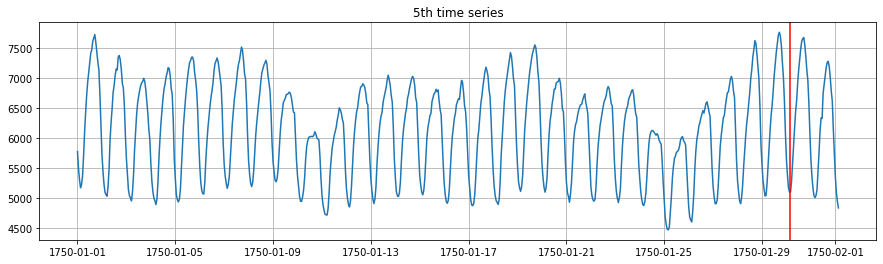

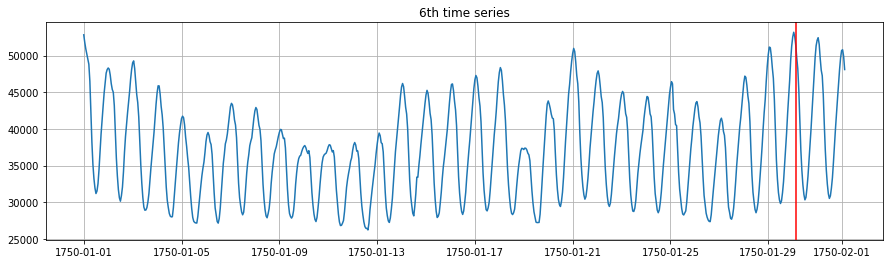

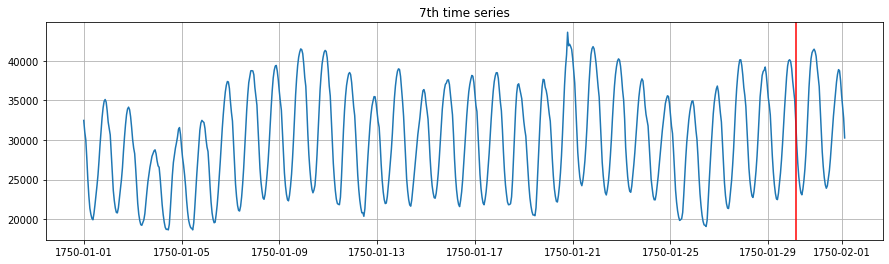

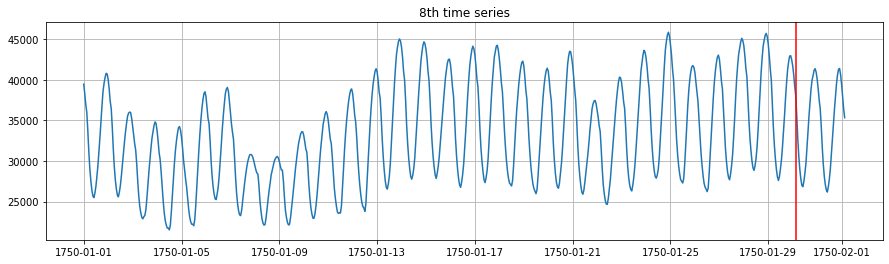

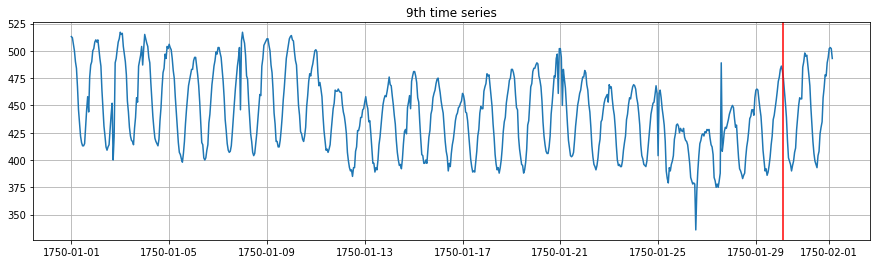

In [73]:
for i in range(10):
    plot_ax(i)

<h1>Modeling</h1>

In [77]:
from gluonts.dataset.common import ListDataset
from gluonts.mx import Trainer
from gluonts.model.deepar import DeepAREstimator
from gluonts.evaluation import make_evaluation_predictions

In [191]:
# ar_estimator = DeepAREstimator(
#     #예측할 frequency data의 metadata '1h' 호출
#     freq = dataset.metadata.freq,
#     # 예측 length: 48개의 timeindex 예측
#     prediction_length=dataset.metadata.prediction_length, 
#     trainer=Trainer(
#         epochs=15,
#         learning_rate=1e-3,
#         num_batches_per_epoch=256
#     ),
#     context_length=100
# )

# ar_predictor = ar_estimator.train(dataset.train)


ar_estimator = DeepAREstimator(
    #예측할 frequency data의 metadata '1h' 호출
    freq = dataset.metadata.freq,
    # 예측 length: 48개의 timeindex 예측
    prediction_length=dataset.metadata.prediction_length, 
    trainer=Trainer(
        epochs=15,
        learning_rate=1e-3,
        num_batches_per_epoch=256
    ),
    context_length=100,
    num_layers=5,
    num_cells=80,
    cell_type='gru'


)

ar_predictor = ar_estimator.train(dataset.train)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base = start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
  0%|          | 0/256 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed 

<h1>총 414개의 time_series 데이터에 대해서 각각 100개씩 샘플링을 진행</h1>

In [192]:
forecast_is,ts_is = make_evaluation_predictions(
    dataset=dataset.test,
    predictor = ar_predictor,
    #각 time serie별로 몇개의 데이터를 샘플링 할것인지
    num_samples = 100
)

In [193]:
forecast = list(forecast_is)
ts = list(ts_is)

/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:340: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._freq_base is None or self._freq_base == start.freq.base
/usr/local/lib/python3.7/dist-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/usr/local/lib/python3.7/dist-packages/gluonts/transform/feature.py:386: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if self._full_range_date_features is not None


<h1>예측값 형태 및 shape 확인</h1>

In [194]:
len(forecast),len(ts)

(414, 414)

<h1></h1>

In [195]:
forecast[0].samples.shape , ts[0].shape

((100, 48), (748, 1))

In [196]:
forecast[0].samples[0]

array([631.06024, 561.0572 , 538.67755, 505.59616, 414.37106, 407.62204,
       417.51248, 402.5635 , 435.5779 , 453.09662, 425.1671 , 517.2793 ,
       629.187  , 687.31433, 694.47986, 749.4421 , 789.53503, 834.7537 ,
       914.8038 , 854.7467 , 872.67413, 848.9918 , 882.24774, 831.0423 ,
       686.9562 , 572.94116, 485.4423 , 454.89346, 443.88525, 476.1742 ,
       499.69135, 503.47162, 531.4751 , 553.30676, 613.95197, 597.84595,
       684.98584, 743.5279 , 703.2135 , 822.35046, 860.0869 , 854.88745,
       826.37134, 847.5076 , 920.7031 , 922.519  , 858.7506 , 755.8938 ],
      dtype=float32)

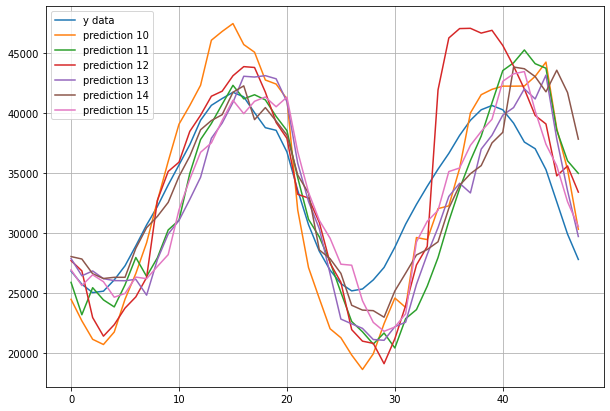

In [197]:
plt.figure(figsize=(10,7))
plt.plot(ts[10][700:].values.reshape(-1,),label='y data')
for i in range(10,16):
    plt.plot(forecast[10].samples[i], label=f'prediction {i}')
plt.legend()
plt.grid(which='both')    

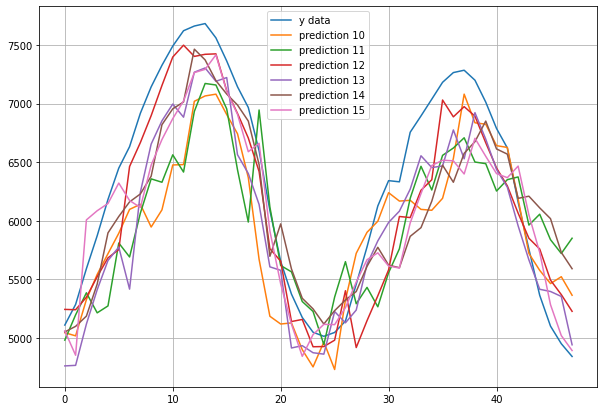

In [187]:
plt.figure(figsize=(10,7))
plt.plot(ts[5][700:].values.reshape(-1,),label='y data')
for i in range(10,16):
    plt.plot(forecast[5].samples[i], label=f'prediction {i}')
plt.legend()
plt.grid(which='both')    

In [121]:
prediction_intervals = (50.0,90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

In [122]:
legend

['observations',
 'median prediction',
 '90.0% prediction interval',
 '50.0% prediction interval']

In [198]:
def plot_prob_forecast(i,ts,forecast):
    plot_length=150
    #신뢰구간
    prediction_interval = (50.0,90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig,ax = plt.subplots(1,1,figsize=(14,6))
    ts[i][-plot_length:].plot(ax=ax)
    forecast[i].plot(prediction_intervals=prediction_intervals,color='g')
    plt.grid(which='both')
    plt.title(f'{i}th item forecast prediction')
    plt.legend(legend,loc='upper left')
    plt.show()

    

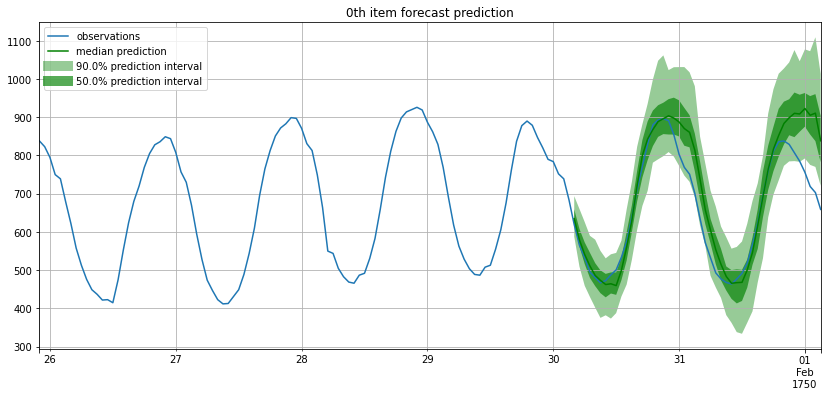

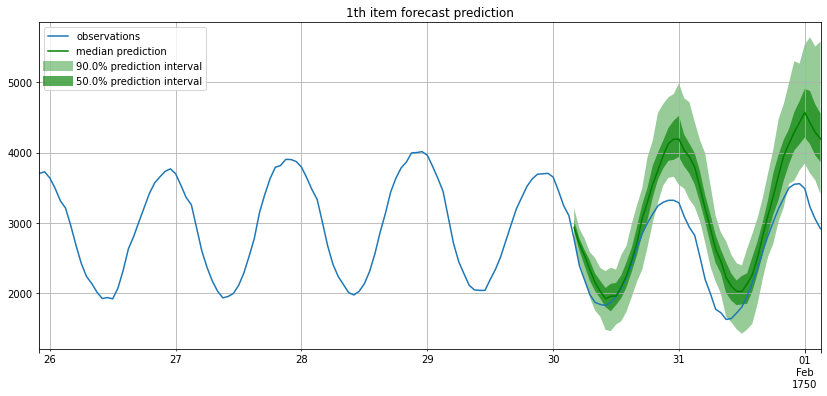

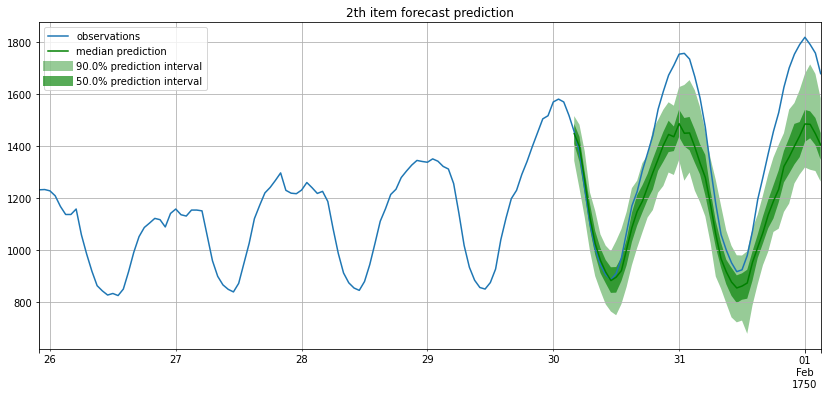

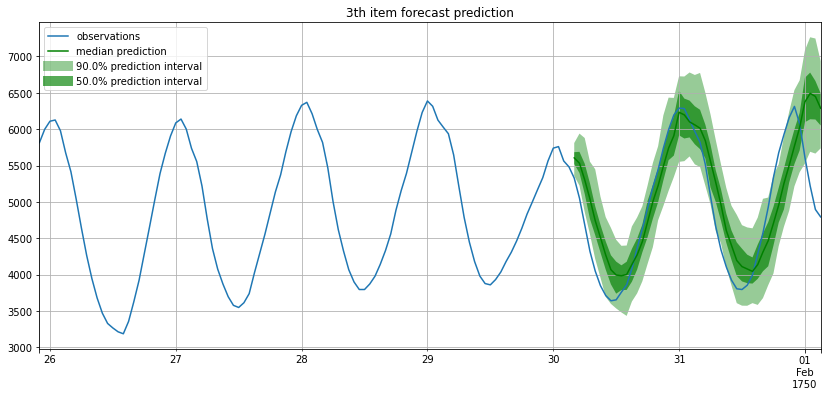

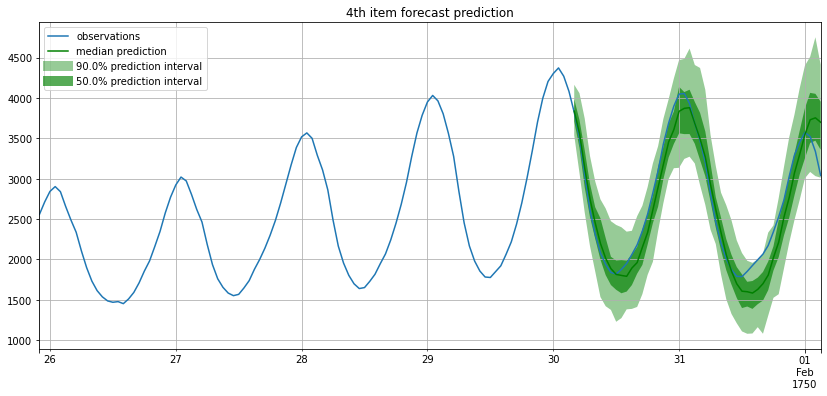

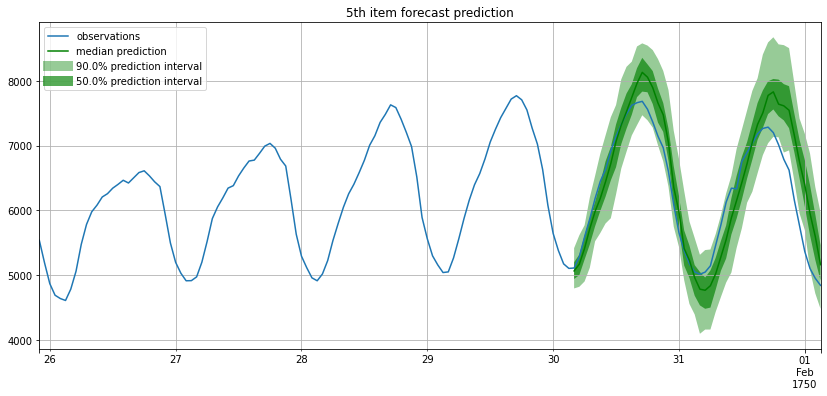

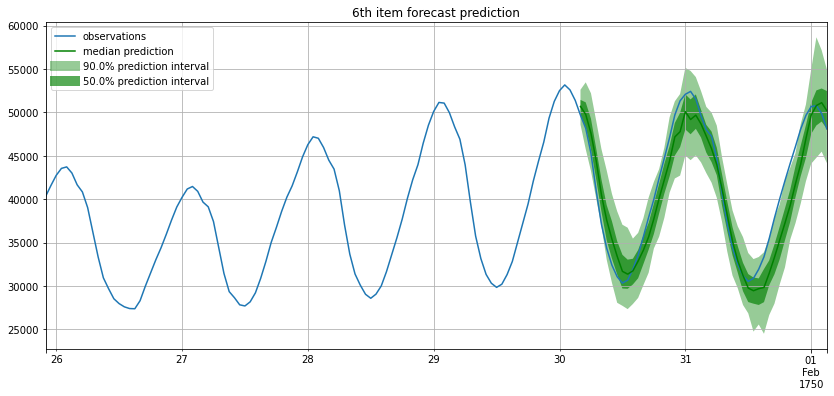

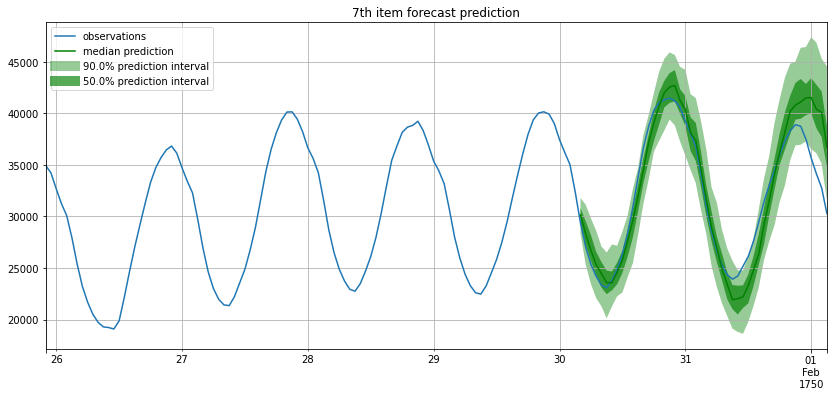

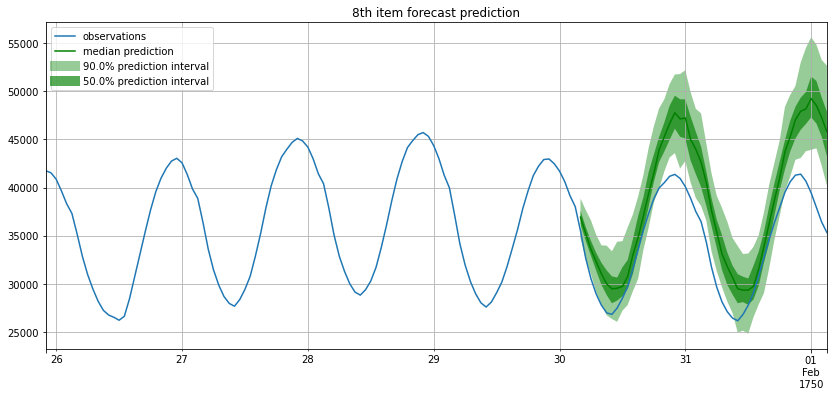

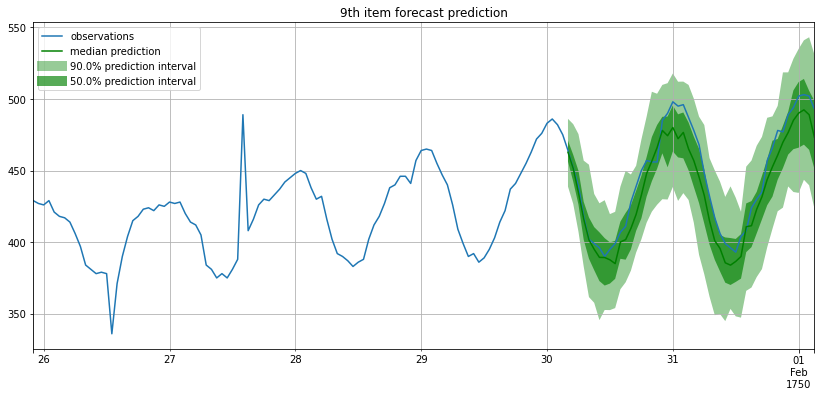

In [199]:
for i in range(10):
    plot_prob_forecast(i,ts,forecast)

In [200]:
from gluonts.evaluation import Evaluator

In [201]:

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(ts), iter(forecast), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 8732.03it/s]/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/usr/local/lib/python3.7/dist-packages/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



In [202]:
print(json.dumps(agg_metrics, indent=2))

{
  "MSE": 10768180.859106274,
  "abs_error": 10812923.786201477,
  "abs_target_sum": 145558863.59960938,
  "abs_target_mean": 7324.822041043147,
  "seasonal_error": 336.9046924038302,
  "MASE": 2.76459566179452,
  "MAPE": 0.17399541413990394,
  "sMAPE": 0.1624119549857726,
  "MSIS": 19.022495225858652,
  "QuantileLoss[0.1]": 6385731.683591462,
  "Coverage[0.1]": 0.13365539452495973,
  "QuantileLoss[0.5]": 10812923.87605381,
  "Coverage[0.5]": 0.5138888888888887,
  "QuantileLoss[0.9]": 4533602.341858863,
  "Coverage[0.9]": 0.8862218196457334,
  "RMSE": 3281.490645896507,
  "NRMSE": 0.44799595505656564,
  "ND": 0.07428557436354219,
  "wQuantileLoss[0.1]": 0.04387044200315259,
  "wQuantileLoss[0.5]": 0.07428557498083427,
  "wQuantileLoss[0.9]": 0.03114617845828682,
  "mean_absolute_QuantileLoss": 7244085.967168045,
  "mean_wQuantileLoss": 0.049767398480757896,
  "MAE_Coverage": 0.020440821256038345,
  "OWA": NaN
}


In [203]:
item_metrics

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,5622.731771,2298.972412,31644.0,659.250000,42.371302,1.130370,0.071255,0.066733,8.226706,1253.677063,0.229167,2298.972412,0.708333,1232.581586,1.000000
1,1.0,438641.000000,25137.492188,124149.0,2586.437500,165.107988,3.171850,0.199099,0.174090,26.847916,17970.793042,0.562500,25137.492310,1.000000,9460.851270,1.000000
2,2.0,39192.302083,7928.914062,65030.0,1354.791667,78.889053,2.093899,0.110967,0.119682,16.922361,2583.380994,0.000000,7928.914124,0.125000,6709.641187,0.395833
3,3.0,300704.354167,20535.578125,235783.0,4912.145833,258.982249,1.651945,0.090104,0.085927,11.523686,12829.646387,0.354167,20535.579102,0.583333,7368.965039,0.895833
4,4.0,51057.307292,8723.500000,131088.0,2731.000000,200.494083,0.906459,0.070950,0.073214,7.393136,5016.113062,0.020833,8723.500122,0.375000,4103.659937,0.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,409.0,539.306315,909.974487,5665.0,118.020833,24.726496,0.766700,0.181520,0.210183,5.153029,441.559164,0.020833,909.974527,0.229167,397.653130,0.875000
410,410.0,240.881307,598.416748,4968.0,103.500000,20.766026,0.600356,0.166766,0.193313,6.516776,342.010520,0.000000,598.416772,0.375000,387.734254,0.979167
411,411.0,159.277140,450.547119,3232.0,67.333333,17.477564,0.537054,0.193323,0.210358,5.810289,268.740130,0.020833,450.547102,0.437500,305.579134,1.000000
412,412.0,165.139689,415.244659,2077.0,43.270833,8.636752,1.001642,0.176196,0.181716,4.904663,162.979982,0.062500,415.244641,0.395833,230.594517,0.770833


In [204]:
# from google.colab import drive
# from pathlib import Path
# drive.mount('/content/gdrive')
# #svae
# ar_predictor.serialize(Path('/content/gdrive/My Drive/Colab Notebooks/deepar/'))

# #load
# from gluonts.model.predictor import Predictor
# ar_copied = Predictor.deserialize(Path('/content/gdrive/My Drive/Colab Notebooks/deepar/'))